# Phase II: Advancing and Regenerating Metrics for Enhanced Behavioral Objectives  

This second phase of the study builds on the foundational analyses in Phase I by introducing new interaction-based metrics and regenerating Phase 1 metrics so they're timestep-based.

## Preparation of the Datasets  

Trajectory data from both TGSIM sites were sorted by agent ID and time, then smoothed using a Gaussian filter to reduce noise. Smoothed x-y positions were used to compute velocity and acceleration through finite differences, with optional smoothing applied to the resulting vectors. A signed acceleration term was then derived by projecting acceleration onto the direction of motion.

This process produced consistent, denoised kinematic variables, including positions, velocities, accelerations, and signed acceleration, for all agents across both datasets.

In [ ]:
# Transforming Coordinates

import pandas as pd

# Loading datasets
tgsim = pd.read_csv("Third_Generation_Simulation_Data__TGSIM__I-395_Trajectories.csv")
fb = pd.read_csv("Third_Generation_Simulation_Data__TGSIM__Foggy_Bottom_Trajectories.csv")

# Calculating H in meters
H_i395 = 2530                       # difference between min and max y coordinate 
conv_i395 = 0.3                     # from documentation
H_meters_i395 = H_i395 * conv_i395

H_fb = 19399                           # difference between min and max y coordinate 
conv_fb = 0.0186613838586    # from documentation
H_meters_fb = H_fb * conv_fb


# Applying transformations to y-coordinates in the I-395 dataset
tgsim["yloc_kf"] = H_meters_i395 - tgsim["yloc_kf"]

# Applying transformations to y-coordinates, y-speeds and y-accelerations in the FB dataset
fb["yloc_kf"] = H_meters_fb - fb["yloc_kf"]
fb["speed_kf_y"] = -fb["speed_kf_y"]
fb["acceleration_kf_y"] = -fb["acceleration_kf_y"]

# Saving transformed datasets
tgsim.to_csv("Transformed_TGSIM_I-395.csv", index=False)
fb.to_csv("Transformed_TGSIM_Foggy_Bottom.csv", index=False)

In [5]:
# Smoothing and Calculation of Variables - I-395 Dataset

import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Loading and sorting dataset
df = pd.read_csv("Transformed_TGSIM_I-395.csv")
df = df.sort_values(by=["id", "time"]).reset_index(drop=True)

# Sampling interval (10 Hz)
dt = 0.1  # seconds per frame

# Helper: Gaussian smoothing
def gaussian_smooth(series, sigma=1.0):
    """Apply Gaussian filter with nearest-edge handling."""
    return pd.Series(
        gaussian_filter1d(series.to_numpy(), sigma=sigma, mode="nearest"),
        index=series.index
    )

# Function to compute v_x, v_y, a_x, a_y
def compute_kinematics(group, sigma=1.0):
    # Smooth positions first
    x_smooth = gaussian_filter1d(group["xloc_kf"].values, sigma=sigma, mode="nearest")
    y_smooth = gaussian_filter1d(group["yloc_kf"].values, sigma=sigma, mode="nearest")

    # First derivatives → velocity
    vx = np.gradient(x_smooth, dt)
    vy = np.gradient(y_smooth, dt)

    # Second derivatives → acceleration
    ax = np.gradient(vx, dt)
    ay = np.gradient(vy, dt)

    # Assign results
    group["xloc_kf_smooth"] = x_smooth
    group["yloc_kf_smooth"] = y_smooth
    group["speed_kf_x"] = vx
    group["speed_kf_y"] = vy
    group["acceleration_kf_x"] = ax
    group["acceleration_kf_y"] = ay

    # Derived magnitudes
    group["speed_kf_smooth"] = np.sqrt(vx**2 + vy**2)
    # Signed acceleration (projection of acceleration on velocity direction)
    speed = np.hypot(vx, vy)
    signed_acc = np.zeros(len(group))

    for i in range(len(group)):
        if speed[i] > 0:
            signed_acc[i] = (vx[i]*ax[i] + vy[i]*ay[i]) / speed[i]
        else:
            signed_acc[i] = 0.0

    group["acceleration_kf"] = signed_acc
    return group

# Apply per agent (id)
df = df.groupby("id", group_keys=False).apply(lambda g: compute_kinematics(g, sigma=1.0))

# Saving final dataset
df.to_csv("Transformed_TGSIM_I-395_smoothed.csv", index=False)

print("Saved dataset with smoothed (x, y), velocity, and acceleration components.")


C:\Users\msela\AppData\Local\Temp\ipykernel_18780\3142125084.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("id", group_keys=False).apply(lambda g: compute_kinematics(g, sigma=1.0))


Saved dataset with smoothed (x, y), velocity, and acceleration components for all AVs and HDVs.


In [8]:
# Foggy Bottom
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Loading and sorting dataset
fb = pd.read_csv("Transformed_TGSIM_Foggy_Bottom.csv")
fb = fb.groupby("id").filter(lambda g: len(g) > 1)
fb = fb.sort_values(by=["id", "time"]).reset_index(drop=True)


# Gaussian smoother
def gaussian_smooth(series, sigma=1.0):
    return pd.Series(
        gaussian_filter1d(series.to_numpy(), sigma=sigma, mode="nearest"),
        index=series.index
    )

# Step 1: smooth positions
fb["xloc_kf_smooth"] = fb.groupby("id")["xloc_kf"].transform(lambda s: gaussian_smooth(s, sigma=1.0))
fb["yloc_kf_smooth"] = fb.groupby("id")["yloc_kf"].transform(lambda s: gaussian_smooth(s, sigma=1.0))

# Step 2: derive velocity components
def compute_velocity(group):
    x = group["xloc_kf_smooth"].values
    y = group["yloc_kf_smooth"].values
    dt = 0.1
    vx, vy = np.zeros(len(group)), np.zeros(len(group))

    for i in range(len(group)):
        if i == 0:
            vx[i] = (x[i+1] - x[i]) / dt
            vy[i] = (y[i+1] - y[i]) / dt
        elif i == len(group)-1:
            vx[i] = (x[i] - x[i-1]) / dt
            vy[i] = (y[i] - y[i-1]) / dt
        else:
            vx[i] = (x[i+1] - x[i-1]) / (2*dt)
            vy[i] = (y[i+1] - y[i-1]) / (2*dt)

    group["speed_kf_x"] = gaussian_filter1d(vx, sigma=1.0, mode="nearest")
    group["speed_kf_y"] = gaussian_filter1d(vy, sigma=1.0, mode="nearest")
    return group

fb = fb.groupby("id", group_keys=False).apply(compute_velocity)

# Step 3: derive acceleration components
def compute_accel(group):
    vx = group["speed_kf_x"].values
    vy = group["speed_kf_y"].values
    dt = 0.1
    ax, ay = np.zeros(len(group)), np.zeros(len(group))

    for i in range(len(group)):
        if i == 0:
            ax[i] = (vx[i+1] - vx[i]) / dt
            ay[i] = (vy[i+1] - vy[i]) / dt
        elif i == len(group)-1:
            ax[i] = (vx[i] - vx[i-1]) / dt
            ay[i] = (vy[i] - vy[i-1]) / dt
        else:
            ax[i] = (vx[i+1] - vx[i-1]) / (2*dt)
            ay[i] = (vy[i+1] - vy[i-1]) / (2*dt)

    group["acceleration_kf_x"] = gaussian_filter1d(ax, sigma=1.0, mode="nearest")
    group["acceleration_kf_y"] = gaussian_filter1d(ay, sigma=1.0, mode="nearest")
    return group

fb = fb.groupby("id", group_keys=False).apply(compute_accel)

# Step 4: signed scalar acceleration and speed
def signed_accel(group):
    vx, vy = group["speed_kf_x"].to_numpy(), group["speed_kf_y"].to_numpy()
    ax, ay = group["acceleration_kf_x"].to_numpy(), group["acceleration_kf_y"].to_numpy()
    speed = np.hypot(vx, vy)
    signed = np.zeros(len(group))
    nz = speed > 0
    signed[nz] = (vx[nz]*ax[nz] + vy[nz]*ay[nz]) / speed[nz]
    group["acceleration_kf_scalar"] = signed

    # now speed
    group["speed_kf_smooth"] = np.sqrt(vx**2 + vy**2)
    return group

fb = fb.groupby("id", group_keys=False).apply(signed_accel)

# Save
fb.to_csv("Transformed_TGSIM_Foggy_Bottom_smoothed.csv", index=False)
print("Smoothed positions, velocity, and acceleration (x, y, signed scalar) computed.")


C:\Users\msela\AppData\Local\Temp\ipykernel_18780\835785095.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fb = fb.groupby("id", group_keys=False).apply(compute_velocity)
C:\Users\msela\AppData\Local\Temp\ipykernel_18780\835785095.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fb = fb.groupby("id", group_keys=False).apply(compute_accel)
C:\Users\msela\AppData\Local\Temp\ipykernel_18780\835785095

Smoothed positions, velocity, and acceleration (x, y, signed scalar) computed.


## Defining Interactions Based on Vision Zones  

Inspired by Tesla Vision’s empirically grounded detection framework, we assign surrounding agents to detection zones around each AV. At every time step, relative distances and angles are computed, normalized to the [0°, 360°] range, and used to determine whether an agent falls into one or more zones. This zone-based classification filters out irrelevant distant agents and records structured interaction logs that capture who interacted with each AV, where, and under what spatial conditions. HDV interactions were also defined using the same method to ensure a common ground for comparison.

In [23]:
# I-395 Dataset - AV
# Now we are creating our two datasets, one for interactions happening between each AV and other agents at each timestep 
# and another for where agent is located with respect to detection zones. 
# Update: assigning interactions as lists since strings don't seem to work - using JSON now.

import pandas as pd
import numpy as np
import json

# Loading our filtered dataset
tgsim = pd.read_csv("Transformed_TGSIM_I-395_smoothed.csv")  # <-- changed filename

# Separating AVs
av_ids = tgsim[tgsim['type_most_common'] == 4]['id'].unique()

# All agents including AVs 
agent_data = tgsim[tgsim['type_most_common'].isin([0, 1, 2, 3, 4, 5, 6, 7])]

# Now getting unique time steps that exist in our dataset
time_steps = sorted(tgsim['time'].unique())

# Defining detection zones again based on Tesla Vision (0° = East)
tesla_zones = {
    "Wide Fwd": {"radius": 60, "angle": 120, "from": 300, "to": 60},
    "Main Fwd": {"radius": 150, "angle": 45, "from": 337.5, "to": 22.5},
    "Narrow Fwd": {"radius": 250, "angle": 35, "from": 342.5, "to": 17.5},
    "Side Fwd L": {"radius": 80, "angle": 90, "from": 25, "to": 115},
    "Side Fwd R": {"radius": 80, "angle": 90, "from": 245, "to": 335},
    "Rear": {"radius": 50, "angle": 135, "from": 112.5, "to": 247.5},
    "Side Rear L": {"radius": 100, "angle": 75, "from": 107.5, "to": 182.5},
    "Side Rear R": {"radius": 100, "angle": 75, "from": 177.5, "to": 252.5}
}

# Ensures angles are in [0, 360] range
def normalize_angle(angle):
    return angle % 360

# Compute heading (0° = East, CCW positive)
def compute_heading(vx, vy):
    return normalize_angle(np.degrees(np.arctan2(vy, vx)))

# Rotate zone definitions to align with direction of travel
def rotate_zones(zones, heading):
    rotated = {}
    for name, params in zones.items():
        from_angle = normalize_angle(params["from"] + heading)
        to_angle = normalize_angle(params["to"] + heading)
        rotated[name] = {
            "radius": params["radius"],
            "angle": params["angle"],
            "from": from_angle,
            "to": to_angle
        }
    return rotated

# Computes relative angle and Euclidean distance
def compute_relative_angle(av, agent):
    dx = agent["xloc_kf_smooth"] - av["xloc_kf_smooth"]
    dy = agent["yloc_kf_smooth"] - av["yloc_kf_smooth"]
    
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.degrees(np.arctan2(dy, dx))  
    angle = normalize_angle(angle)  

    return angle, distance

# Determines detection zones based on angle and distance
def detect_zones(relative_angle, distance, zones):
    detected_zones = []
    rel_angle = normalize_angle(relative_angle)

    for zone, params in zones.items():
        from_angle, to_angle = params["from"], params["to"]

        # Handling cases where the zone wraps around 360 degrees
        if from_angle > to_angle:
            within_angle = (rel_angle >= from_angle or rel_angle <= to_angle)
        else:
            within_angle = (from_angle <= rel_angle <= to_angle)

        if within_angle and distance <= params["radius"]:
            detected_zones.append(zone)

    return detected_zones

# Compute and fill heading for all agents
tgsim["heading"] = (
    np.degrees(np.arctan2(tgsim["speed_kf_y"], tgsim["speed_kf_x"]))
)
tgsim["heading"] = (
    tgsim.groupby("id")["heading"].transform(lambda x: x.ffill().bfill())
)
tgsim["heading"] = tgsim["heading"].apply(normalize_angle)

# Initializing storage for our two datasets
interaction_log_data = []
detection_details = []

# Processing each time step
for timestep in time_steps:
    av_positions = tgsim[(tgsim['time'] == timestep) & (tgsim['type_most_common'] == 4)]
    agent_positions = agent_data[agent_data['time'] == timestep]

    for av_id in av_ids:
        av_row = av_positions[av_positions['id'] == av_id]
        if av_row.empty:
            continue

        av_row = av_row.iloc[0]
        heading = av_row["heading"]
        rotated_zones = rotate_zones(tesla_zones, heading)

        interacting_agents = []

        for _, agent_row in agent_positions.iterrows():
            agent_id = agent_row['id']
            relative_angle, distance = compute_relative_angle(av_row, agent_row)

            if distance < 0.01:
                continue

            detected_zones = detect_zones(relative_angle, distance, rotated_zones)

            if detected_zones:
                interacting_agents.append(int(agent_id))
                detection_details.append({
                    "time": float(timestep),
                    "av_id": int(av_id),
                    "agent_id": int(agent_id),
                    "zones": detected_zones,  
                    "distance": float(distance)
                })

        if interacting_agents:
            interaction_log_data.append({
                "time": float(timestep),
                "av_id": int(av_id),
                "agent_ids": interacting_agents
            })

    if timestep % 100 == 0:
        print(f"Processed time {timestep}")

# Save datasets as JSON with proper formatting
with open("AV_Interaction_Log_I395.json", "w") as f:  # <-- changed filename
    json.dump(interaction_log_data, f, indent=2)

with open("AV_Detection_Details_I395.json", "w") as f:  # <-- changed filename
    json.dump(detection_details, f, indent=2)

print("Processing complete. Datasets saved as JSON for I-395.")


Processed time 100.0
Processed time 200.0
Processed time 300.0
Processed time 400.0
Processed time 500.0
Processed time 600.0
Processed time 700.0
Processed time 800.0
Processed time 900.0
Processed time 1000.0
Processed time 1100.0
Processed time 1200.0
Processed time 1300.0
Processed time 1400.0
Processed time 1500.0
Processed time 1600.0
Processed time 1700.0
Processed time 1800.0
Processed time 1900.0
Processed time 2000.0
Processed time 2100.0
Processed time 2200.0
Processed time 2300.0
Processed time 2400.0
Processed time 2500.0
Processed time 2600.0
Processed time 2700.0
Processed time 2800.0
Processed time 2900.0
Processed time 3000.0
Processed time 3100.0
Processed time 3200.0
Processed time 3300.0
Processed time 3400.0
Processed time 3500.0
Processed time 3600.0
Processed time 3700.0
Processed time 3800.0
Processed time 3900.0
Processed time 4000.0
Processed time 4100.0
Processed time 4200.0
Processed time 4300.0
Processed time 4400.0
Processed time 4500.0
Processed time 4600

In [24]:
# Foggy Bottom - AV
# Now we are creating our two datasets, one for interactions happening between each AV and other agents at each timestep 
# and another for where agent is located with respect to detection zones. 
# Update: assigning interactions as lists since strings don't seem to work - using JSON now.
# Update 2: rotating Tesla Vision zones based on AV heading (0° = East, CCW positive).

import pandas as pd
import numpy as np
import json

# Loading our filtered dataset
tgsim = pd.read_csv("Transformed_TGSIM_Foggy_Bottom_smoothed.csv")

# Separating AVs
av_ids = tgsim[tgsim['type_most_common'] == 4]['id'].unique()

# All agents including AVs 
agent_data = tgsim[tgsim['type_most_common'].isin([0, 1, 2, 3, 4, 5, 6, 7])]

# Now getting unique time steps that exist in our dataset
time_steps = sorted(tgsim['time'].unique())

# Defining detection zones again based on Tesla Vision (0° = East)
tesla_zones = {
    "Wide Fwd": {"radius": 60, "angle": 120, "from": 300, "to": 60},
    "Main Fwd": {"radius": 150, "angle": 45, "from": 337.5, "to": 22.5},
    "Narrow Fwd": {"radius": 250, "angle": 35, "from": 342.5, "to": 17.5},
    "Side Fwd L": {"radius": 80, "angle": 90, "from": 25, "to": 115},
    "Side Fwd R": {"radius": 80, "angle": 90, "from": 245, "to": 335},
    "Rear": {"radius": 50, "angle": 135, "from": 112.5, "to": 247.5},
    "Side Rear L": {"radius": 100, "angle": 75, "from": 107.5, "to": 182.5},
    "Side Rear R": {"radius": 100, "angle": 75, "from": 177.5, "to": 252.5}
}

# Ensures angles are in [0, 360] range
def normalize_angle(angle):
    return angle % 360

# Compute heading (0° = East, CCW positive)
def compute_heading(vx, vy):
    return normalize_angle(np.degrees(np.arctan2(vy, vx)))

# Rotate zone definitions to align with direction of travel
def rotate_zones(zones, heading):
    rotated = {}
    for name, params in zones.items():
        from_angle = normalize_angle(params["from"] + heading)
        to_angle = normalize_angle(params["to"] + heading)
        rotated[name] = {
            "radius": params["radius"],
            "angle": params["angle"],
            "from": from_angle,
            "to": to_angle
        }
    return rotated

# Computes relative angle and Euclidean distance
def compute_relative_angle(av, agent):
    dx = agent["xloc_kf_smooth"] - av["xloc_kf_smooth"]
    dy = agent["yloc_kf_smooth"] - av["yloc_kf_smooth"]
    
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.degrees(np.arctan2(dy, dx))  
    angle = normalize_angle(angle)  

    return angle, distance

# Determines detection zones based on angle and distance
def detect_zones(relative_angle, distance, zones):
    detected_zones = []
    rel_angle = normalize_angle(relative_angle)

    for zone, params in zones.items():
        from_angle, to_angle = params["from"], params["to"]

        # Handling cases where the zone wraps around 360 degrees
        if from_angle > to_angle:
            within_angle = (rel_angle >= from_angle or rel_angle <= to_angle)
        else:
            within_angle = (from_angle <= rel_angle <= to_angle)

        if within_angle and distance <= params["radius"]:
            detected_zones.append(zone)

    return detected_zones

# Compute and fill heading for all agents
tgsim["heading"] = np.degrees(np.arctan2(tgsim["speed_kf_y"], tgsim["speed_kf_x"]))
tgsim["heading"] = tgsim.groupby("id")["heading"].transform(lambda x: x.ffill().bfill())
tgsim["heading"] = tgsim["heading"].apply(normalize_angle)

# Initializing storage for our two datasets
interaction_log_data = []
detection_details = []

# Processing each time step
for timestep in time_steps:
    av_positions = tgsim[(tgsim['time'] == timestep) & (tgsim['type_most_common'] == 4)]
    agent_positions = agent_data[agent_data['time'] == timestep]

    for av_id in av_ids:
        av_row = av_positions[av_positions['id'] == av_id]
        if av_row.empty:
            continue

        av_row = av_row.iloc[0]
        heading = av_row["heading"]
        rotated_zones = rotate_zones(tesla_zones, heading)

        interacting_agents = []

        for _, agent_row in agent_positions.iterrows():
            agent_id = agent_row['id']
            relative_angle, distance = compute_relative_angle(av_row, agent_row)

            if distance < 0.01:
                continue

            detected_zones = detect_zones(relative_angle, distance, rotated_zones)

            if detected_zones:
                interacting_agents.append(int(agent_id))
                detection_details.append({
                    "time": float(timestep),
                    "av_id": int(av_id),
                    "agent_id": int(agent_id),
                    "zones": detected_zones,  
                    "distance": float(distance)
                })

        if interacting_agents:
            interaction_log_data.append({
                "time": float(timestep),
                "av_id": int(av_id),
                "agent_ids": interacting_agents
            })

    if timestep % 100 == 0:
        print(f"Processed time {timestep}")

# Save datasets as JSON with proper formatting
with open("AV_Interaction_Log_FB.json", "w") as f:
    json.dump(interaction_log_data, f, indent=2)

with open("AV_Detection_Details_FB.json", "w") as f:
    json.dump(detection_details, f, indent=2)

print("Processing complete. Datasets saved as JSON for Foggy Bottom.")


Processed time 100.0
Processed time 200.0
Processed time 300.0
Processed time 400.0
Processed time 500.0
Processed time 600.0
Processed time 700.0
Processed time 800.0
Processed time 900.0
Processed time 1000.0
Processed time 1100.0
Processed time 1200.0
Processed time 1300.0
Processed time 1400.0
Processed time 1500.0
Processed time 1600.0
Processed time 1700.0
Processed time 1800.0
Processed time 1900.0
Processed time 2000.0
Processed time 2100.0
Processed time 2200.0
Processed time 2300.0
Processed time 2400.0
Processed time 2500.0
Processed time 2600.0
Processed time 2700.0
Processed time 2800.0
Processed time 2900.0
Processed time 3000.0
Processed time 3100.0
Processed time 3200.0
Processed time 3300.0
Processed time 3400.0
Processed time 3500.0
Processed time 3600.0
Processed time 3700.0
Processed time 3800.0
Processed time 3900.0
Processed time 4000.0
Processed time 4100.0
Processed time 4200.0
Processed time 4300.0
Processed time 4400.0
Processed time 4500.0
Processed time 4600

## Calculation of GSSM  

To replace rigid one-dimensional surrogates like TTC and PET, we implement a spacing-based risk score (GSSM) that evaluates collision likelihood from multi-directional interactions. Spacing distributions are conditioned on contextual features such as relative velocity, short-term kinematics, and road setting. The resulting metric quantifies how unusual an observed spacing is compared to typical patterns, providing a unified safety signal across merging, crossing, and following scenarios.  

In [20]:
# Step 1: generating a unified dataset for training

import pandas as pd
import json

# Loading datasets
fb = pd.read_csv("Transformed_TGSIM_Foggy_Bottom_smoothed.csv")
i395 = pd.read_csv("Transformed_TGSIM_I-395_smoothed.csv")

# Mapping types (they're different between the two datasets)
fb_type_map = {
    0: "pedestrian",
    1: "bicycle",
    2: "scooter",
    3: "passenger car",
    4: "AV",
    5: "motorcycle",
    6: "bus",
    7: "truck"
}

i395_type_map = {
    1: "passenger car",
    2: "truck",
    3: "bus",
    4: "AV"
}

# Loading JSONs
def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

# Loading detection details
fb_det = load_json("AV_Detection_Details_FB.json")
i395_det = load_json("AV_Detection_Details_I395.json")

# Converint to dataframes
fb_det_df = pd.DataFrame(fb_det)
i395_det_df = pd.DataFrame(i395_det)

# Adding roadway type based on dataset
fb_det_df["roadway_type"] = "urban intersection"
i395_det_df["roadway_type"] = "highway"

# Merging detection info with state data
def build_interaction_df(det_df, state_df, type_map):
    # Agent kinematics
    merged = det_df.merge(
        state_df,
        left_on=["time", "agent_id"],
        right_on=["time", "id"],
        suffixes=("", "_agent")
    )
    
    # AV kinematics
    av_state = state_df.rename(
        columns={col: col + "_av" for col in state_df.columns if col not in ["time"]}
    )
    merged = merged.merge(
        av_state,
        left_on=["time", "av_id"],
        right_on=["time", "id_av"],
        suffixes=("", "_av")
    )
    
    # Mapped types
    merged["type_agent"] = merged["type_most_common"].map(type_map)
    merged["type_av"] = merged["type_most_common_av"].map(type_map)

    # we're specifying if current interaction is with a VRU or if a VRU is nearby
    vru_types = {"pedestrian", "bicycle", "scooter"}
    merged["is_vru"] = merged["type_agent"].isin(vru_types).map({True: "Yes", False: "No"})
    merged["has_vru"] = merged.groupby(["time", "av_id"])["is_vru"] \
                              .transform(lambda x: "Yes" if x.any() else "No")

    # we're specifying if current interaction is with a heavy vehicle or if a heavy vehicle is nearby
    hv_types = {"bus", "truck"}
    merged["is_hv"] = merged["type_agent"].isin(hv_types).map({True: "Yes", False: "No"})
    merged["has_hv"] = merged.groupby(["time", "av_id"])["is_hv"] \
                              .transform(lambda x: "Yes" if x.any() else "No")

    # Same lane context variable
    merged["same_lane"] = (merged["lane_kf"] == merged["lane_kf_av"]).map({True: "Yes", False: "No"})

    # Agent rank in terms of proximity
    merged["rank_agent"] = merged.groupby(["time", "av_id"])["distance"] \
                               .rank(method="first", ascending=True).astype(int)
    merged["rank_agent"] = merged["rank_agent"].clip(upper=10)                      # lumping ranks 10 and above in one class

    # Adding no. of agents within a speed-dependent range
    merged["vx_av"] = merged["speed_kf_x_av"]
    merged["vy_av"] = merged["speed_kf_y_av"]
    merged["speed_av"] = np.sqrt(merged["vx_av"]**2 + merged["vy_av"]**2)
    
    def compute_density(g):
        r = max(20, g["speed_av"].iloc[0] * 3)
        return (g["distance"] <= r).sum()  # count nearby agents

    merged["dynamic_density"] = (
        merged.groupby(["time", "av_id"])
              .apply(compute_density)
              .reindex(merged.set_index(["time", "av_id"]).index)
              .values
    )
    
    # This is the final unified format
    final = pd.DataFrame({
        "time": merged["time"],
        "av_id": merged["av_id"],
        "agent_id": merged["agent_id"],  
        "distance": merged["distance"],
        # Agent state
        "xloc_agent": merged["xloc_kf_smooth"],
        "yloc_agent": merged["yloc_kf_smooth"],
        "lane_agent": merged["lane_kf"],
        "vx_agent": merged["speed_kf_x"],
        "vy_agent": merged["speed_kf_y"],
        "acc_agent": merged["acceleration_kf_scalar"] if "acceleration_kf_scalar" in merged else merged["acceleration_kf"],
        "type_agent": merged["type_agent"],
        "rank_agent": merged["rank_agent"],
        # AV state
        "xloc_av": merged["xloc_kf_smooth_av"],
        "yloc_av": merged["yloc_kf_smooth_av"],
        "lane_av": merged["lane_kf_av"],
        "vx_av": merged["speed_kf_x_av"],
        "vy_av": merged["speed_kf_y_av"],
        "acc_av": merged["acceleration_kf_scalar_av"] if "acceleration_kf_scalar_av" in merged else merged["acceleration_kf_av"],

        "type_av": merged["type_av"],
        # Context
        "roadway_type": merged["roadway_type"],
        "zone": merged["zones"].apply(lambda z: ", ".join(z)),
        "is_vru": merged["is_vru"],
        "has_vru": merged["has_vru"],
        "is_hv": merged["is_hv"],
        "has_hv": merged["has_hv"],
        "same_lane": merged["same_lane"],
        "dynamic_density": merged["dynamic_density"]
    })
    
    return final

fb_interactions = build_interaction_df(fb_det_df, fb, fb_type_map)
i395_interactions = build_interaction_df(i395_det_df, i395, i395_type_map)

# Combining into a unified training set
unified_interactions = pd.concat([fb_interactions, i395_interactions], ignore_index=True)

unified_interactions.to_csv("Unified_TGSIM_Interactions.csv", index=False)

print("Unified interaction dataset created with shape:", unified_interactions.shape)
print(unified_interactions.head())


C:\Users\msela\AppData\Local\Temp\ipykernel_6280\3980709266.py:102: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_density)
C:\Users\msela\AppData\Local\Temp\ipykernel_6280\3980709266.py:102: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_density)


Unified interaction dataset created with shape: (699275, 27)
    time  av_id  agent_id   distance  xloc_agent  yloc_agent  lane_agent  \
0  950.0   4716      3399  88.116236   97.979194  164.039164          32   
1  950.0   4716      3807  39.132024  189.300555  182.758062          27   
2  950.0   4716     18352  33.720958  181.560720  177.663109          42   
3  950.0   4716     18354  28.887297  185.413420  172.857599          42   
4  950.0   4716     18356  20.195269  195.610109  160.390931          44   

   vx_agent  vy_agent  acc_agent  ...    acc_av  type_av        roadway_type  \
0 -7.224933  0.008856   0.544363  ...  0.010433       AV  urban intersection   
1 -0.001074  0.018196   0.024873  ...  0.010433       AV  urban intersection   
2  1.761773 -0.464592  -0.066631  ...  0.010433       AV  urban intersection   
3  2.358280 -0.204260   0.035922  ...  0.010433       AV  urban intersection   
4  1.009048  1.161633  -1.080211  ...  0.010433       AV  urban intersection   

 

In [21]:
# Step 2: Compute GSSM features + enrich with context (X)

import pandas as pd
import numpy as np

unified_interactions = pd.read_csv("Unified_TGSIM_Interactions.csv")

def compute_gssm_and_context(df):
    # Relative velocity
    df["rel_vx"] = df["vx_av"] - df["vx_agent"]
    df["rel_vy"] = df["vy_av"] - df["vy_agent"]
    df["rel_speed"] = np.sqrt(df["rel_vx"]**2 + df["rel_vy"]**2)
    
    # Relative position
    df["rel_x"] = df["xloc_agent"] - df["xloc_av"]
    df["rel_y"] = df["yloc_agent"] - df["yloc_av"]
    
    # Rotating into relative velocity or heading frame
    def rotate(row):
        # relative velocity between agent (i) and AV (j)
        vx_axis = row["vx_agent"] - row["vx_av"]
        vy_axis = row["vy_agent"] - row["vy_av"]
        norm = np.hypot(vx_axis, vy_axis)

        # fallback: if relative velocity is ~0, use agent's own heading as axis
        if norm < 1e-6:
            vx_axis, vy_axis = row["vx_agent"], row["vy_agent"]
            norm = np.hypot(vx_axis, vy_axis)
            # if the agent is also stationary, spacing cannot be defined
            if norm < 1e-6:
                return 0.0, 0.0

        # construct rotation matrix from Eq. (2) in the paper
        R = np.array([[vy_axis, -vx_axis],
                      [vx_axis,  vy_axis]]) / norm

        # relative position (j relative to i)
        rel = np.array([row["xloc_av"] - row["xloc_agent"],
                        row["yloc_av"] - row["yloc_agent"]])

        rotated = R @ rel
        return rotated[0], rotated[1]
    
    # Apply rotation row-wise
    rotated = df.apply(rotate, axis=1, result_type="expand")
    df["rho_ij"] = rotated[0]
    df["s_ij"] = rotated[1]

    # Agent / AV speed magnitudes
    df["speed_agent"] = np.sqrt(df["vx_agent"]**2 + df["vy_agent"]**2)
    df["speed_av"] = np.sqrt(df["vx_av"]**2 + df["vy_av"]**2)

    # Final column ordering
    cols = [
        "time", "av_id", "agent_id",
        "s_ij", "rho_ij", "rel_speed",
        "zone", "roadway_type", "is_vru",
        "has_vru", "is_hv", "has_hv", 
        "same_lane", "dynamic_density",
        # Agent state
        "type_agent", "lane_agent", "vx_agent", "vy_agent", "speed_agent", "acc_agent", "rank_agent",
        # AV state
        "type_av", "lane_av", "vx_av", "vy_av", "speed_av", "acc_av"
    ]
    return df[cols]

gssm_context_df = compute_gssm_and_context(unified_interactions)

gssm_context_df.to_csv("GSSM_Context_Features.csv", index=False)

print("Context + GSSM dataset created:", gssm_context_df.shape)
print(gssm_context_df.head())


Context + GSSM dataset created: (699275, 27)
    time  av_id  agent_id       s_ij     rho_ij  rel_speed  \
0  950.0   4716      3399 -85.831747 -19.934450   7.218663   
1  950.0   4716      3807 -38.639746   6.187515   0.017593   
2  950.0   4716     18352  10.731049  31.967915   1.828422   
3  950.0   4716     18354   0.881933  28.873832   2.373480   
4  950.0   4716     18356 -20.106754   1.888739   1.541767   

                   zone        roadway_type is_vru has_vru  ...  vy_agent  \
0           Side Rear L  urban intersection     No     Yes  ...  0.008856   
1            Side Fwd L  urban intersection     No     Yes  ...  0.018196   
2            Side Fwd L  urban intersection    Yes     Yes  ... -0.464592   
3            Side Fwd L  urban intersection    Yes     Yes  ... -0.204260   
4  Wide Fwd, Side Fwd L  urban intersection    Yes     Yes  ...  1.161633   

  speed_agent acc_agent  rank_agent type_av  lane_av     vx_av     vy_av  \
0    7.224939  0.544363           5      AV

In [22]:
# Step 3: Preprocessing for GSSM training (with absolute spacing)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import numpy as np

# Load the dataset
context_features = pd.read_csv("GSSM_Context_Features.csv")
# spacing values less than 0.5 are practically crashes, which shouldn't be the case since the dataset does not include crashes. 
#context_features = context_features[(context_features["s_ij"] > 0.5) | ((context_features["s_ij"] < -0.5)) ]


# --- Target variable (spacing) ---
# Enforce absolute positive spacing with epsilon (to avoid log(0))
eps = 1e-6
y = np.abs(context_features["s_ij"].values) + eps

# --- Feature set (conditioning features) ---
numeric_features = ["rho_ij", "rel_speed",
                    "speed_agent", "acc_agent",
                    "speed_av", "acc_av", "dynamic_density"]

categorical_features = ["lane_agent", "lane_av",
                        "type_agent", "roadway_type", "zone",
                        "is_vru", "has_vru", "is_hv", "has_hv",
                        "same_lane", "rank_agent"]

X = context_features[numeric_features + categorical_features]

# --- Preprocessing: scale numeric, one-hot encode categorical ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Apply preprocessing
X_transformed = pipeline.fit_transform(X)

# Save preprocessor for later use (in NN training)
joblib.dump(pipeline, "gssm_preprocessor.pkl")

# --- Train/val/test split ---
X_train, X_temp, y_train, y_temp = train_test_split(X_transformed, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

# Save splits to disk as dense arrays
np.savez_compressed(
    "gssm_train_val_test.npz",
    X_train=X_train.toarray() if hasattr(X_train, "toarray") else X_train,
    y_train=y_train.values if hasattr(y_train, "values") else y_train,
    X_val=X_val.toarray() if hasattr(X_val, "toarray") else X_val,
    y_val=y_val.values if hasattr(y_val, "values") else y_val,
    X_test=X_test.toarray() if hasattr(X_test, "toarray") else X_test,
    y_test=y_test.values if hasattr(y_test, "values") else y_test,
)



Shapes:
Train: (489492, 131) (489492,)
Val: (104891, 131) (104891,)
Test: (104892, 131) (104892,)


In [23]:
# Step 4: PyTorch GSSM Model

import torch
import torch.nn as nn
import torch.nn.functional as F

# GSSM model definition
class GSSM(nn.Module):
    def __init__(self, input_dim):
        super(GSSM, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, 1)         # output mean
        self.fc_log_sigma = nn.Linear(64, 1)  # output log std

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)                     # μ
        log_sigma = self.fc_log_sigma(h)       # log(σ)
        return mu, log_sigma

# Log-normal negative log-likelihood
def lognormal_nll(y, mu, log_sigma):
    sigma = torch.exp(log_sigma)
    return torch.mean(
        0.5 * ((torch.log(y + 1e-6) - mu) / sigma) ** 2
        + log_sigma
        + torch.log(y + 1e-6)
    )

# Example init
input_dim = 131  # from our preprocessing
model = GSSM(input_dim)

print(model)


GSSM(
  (fc1): Linear(in_features=131, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc_mu): Linear(in_features=64, out_features=1, bias=True)
  (fc_log_sigma): Linear(in_features=64, out_features=1, bias=True)
)


In [24]:
# Step 5: Training Loop for GSSM (log-space targets)

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from scipy.sparse import issparse

#Loading train/val/test splits
data = np.load("gssm_train_val_test.npz", allow_pickle=True)

def ensure_dense_float(arr):
    if issparse(arr):
        arr = arr.toarray()
    if hasattr(arr, "toarray"):
        arr = arr.toarray()
    if hasattr(arr, "values"):
        arr = arr.values
    return np.asarray(arr, dtype=np.float32)

X_train, y_train = ensure_dense_float(data["X_train"]), ensure_dense_float(data["y_train"])
X_val, y_val = ensure_dense_float(data["X_val"]), ensure_dense_float(data["y_val"])
X_test, y_test = ensure_dense_float(data["X_test"]), ensure_dense_float(data["y_test"])

# Converting y to log-space (we'll add epsilon to avoid log(0))
eps = 1e-6
y_train_log = np.log(y_train + eps)
y_val_log   = np.log(y_val + eps)
y_test_log  = np.log(y_test + eps)

# Convert to torch tensors
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train_log).unsqueeze(1))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val_log).unsqueeze(1))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test_log).unsqueeze(1))

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Our model
input_dim = X_train.shape[1]

class GSSM(nn.Module):
    def __init__(self, input_dim):
        super(GSSM, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, 1)         # mean of log(s)
        self.fc_log_sigma = nn.Linear(64, 1)  # log std of log(s)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_log_sigma(h)
        return mu, log_sigma

# Gaussian NLL in log-space
def gaussian_nll_weighted(y, mu, log_sigma, alpha=0.5):
    """
    y: log(s) targets
    mu, log_sigma: model outputs
    alpha: weighting exponent (0=no weight, 1=full 1/y scaling)
    """
    sigma = torch.exp(log_sigma)
    
    # Standard Gaussian NLL (per-sample)
    nll = 0.5 * ((y - mu) / sigma) ** 2 + log_sigma + 0.5 * np.log(2 * np.pi)
    
    # Weight = inverse of exp(y)^alpha (since y is log(s))
    weights = torch.exp(-alpha * y)   # smaller spacing is assigned larger weight
    
    return torch.mean(weights * nll)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GSSM(input_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# This is our training loop
n_epochs = 25   # longer training
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        mu, log_sigma = model(X_batch)
        loss = gaussian_nll_weighted(y_batch, mu, log_sigma, alpha=0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(X_batch)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            mu, log_sigma = model(X_batch)
            loss = gaussian_nll_weighted(y_batch, mu, log_sigma, alpha=0)    #alpha=0 --> currently not weighting
            val_loss += loss.item() * len(X_batch)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

torch.save(model.state_dict(), "gssm_model_logspace.pth")
print("Training complete, model saved as gssm_model_logspace.pth")


Epoch 1/25, Train Loss: 0.8803, Val Loss: 0.5162
Epoch 2/25, Train Loss: 0.3997, Val Loss: 0.3390
Epoch 3/25, Train Loss: 0.3069, Val Loss: 0.2712
Epoch 4/25, Train Loss: 0.2573, Val Loss: 0.2521
Epoch 5/25, Train Loss: 0.2236, Val Loss: 0.2133
Epoch 6/25, Train Loss: 0.1950, Val Loss: 0.2281
Epoch 7/25, Train Loss: 0.1779, Val Loss: 0.1872
Epoch 8/25, Train Loss: 0.1595, Val Loss: 0.2052
Epoch 9/25, Train Loss: 0.1459, Val Loss: 0.1469
Epoch 10/25, Train Loss: 0.1312, Val Loss: 0.1401
Epoch 11/25, Train Loss: 0.1223, Val Loss: 0.1520
Epoch 12/25, Train Loss: 0.1120, Val Loss: 0.1296
Epoch 13/25, Train Loss: 0.1050, Val Loss: 0.1247
Epoch 14/25, Train Loss: 0.0925, Val Loss: 0.1329
Epoch 15/25, Train Loss: 0.0868, Val Loss: 0.2229
Epoch 16/25, Train Loss: 0.0799, Val Loss: 0.1014
Epoch 17/25, Train Loss: 0.0743, Val Loss: 0.0844
Epoch 18/25, Train Loss: 0.0661, Val Loss: 0.0752
Epoch 19/25, Train Loss: 0.0609, Val Loss: 0.1434
Epoch 20/25, Train Loss: 0.0562, Val Loss: 0.1259
Epoch 21/

In [25]:
# Step 5.b: Training Loop for GSSM Residuals

# --- Load the trained base model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_base = GSSM(input_dim).to(device)
model_base.load_state_dict(torch.load("gssm_model_logspace.pth", map_location=device))
model_base.eval()

# --- Compute residuals on train/val sets ---
with torch.no_grad():
    mu_train, _ = model_base(torch.tensor(X_train).to(torch.float32).to(device))
    mu_val, _   = model_base(torch.tensor(X_val).to(torch.float32).to(device))

y_pred_train = np.exp(mu_train.cpu().numpy()).flatten()
y_pred_val   = np.exp(mu_val.cpu().numpy()).flatten()

residuals_train = y_train.flatten() - y_pred_train
residuals_val   = y_val.flatten() - y_pred_val

# --- Residual model ---
class ResidualNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

res_model = ResidualNet(X_train.shape[1])
opt = torch.optim.Adam(res_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# --- DataLoaders ---
train_ds = TensorDataset(torch.tensor(X_train).float(),
                         torch.tensor(residuals_train).float().unsqueeze(1))
val_ds   = TensorDataset(torch.tensor(X_val).float(),
                         torch.tensor(residuals_val).float().unsqueeze(1))
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=512)

# --- Train loop ---
for epoch in range(25):
    res_model.train()
    train_loss = 0
    for xb, yb in train_dl:
        pred = res_model(xb)
        loss = criterion(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()*len(xb)
    train_loss /= len(train_dl.dataset)

    # validation
    res_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            pred = res_model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()*len(xb)
    val_loss /= len(val_dl.dataset)
    print(f"Epoch {epoch+1}: Train {train_loss:.4f}, Val {val_loss:.4f}")

torch.save(res_model.state_dict(), "gssm_residual_net.pth")

Epoch 1: Train 95.0810, Val 94.7824
Epoch 2: Train 92.8164, Val 93.7740
Epoch 3: Train 91.8978, Val 92.8706
Epoch 4: Train 91.1652, Val 92.8327
Epoch 5: Train 90.4172, Val 91.4910
Epoch 6: Train 89.6537, Val 90.7954
Epoch 7: Train 88.9760, Val 90.6867
Epoch 8: Train 88.2837, Val 90.2549
Epoch 9: Train 87.6656, Val 88.9705
Epoch 10: Train 87.0012, Val 88.7202
Epoch 11: Train 86.3649, Val 88.1923
Epoch 12: Train 85.8110, Val 87.7092
Epoch 13: Train 85.2482, Val 87.3986
Epoch 14: Train 84.7065, Val 86.3921
Epoch 15: Train 84.1163, Val 85.6702
Epoch 16: Train 83.6740, Val 85.0205
Epoch 17: Train 83.1246, Val 84.4676
Epoch 18: Train 82.6627, Val 84.8337
Epoch 19: Train 82.2036, Val 84.5636
Epoch 20: Train 81.7444, Val 83.9591
Epoch 21: Train 81.3145, Val 82.5905
Epoch 22: Train 80.9100, Val 82.6982
Epoch 23: Train 80.5051, Val 82.7687
Epoch 24: Train 80.1236, Val 81.8067
Epoch 25: Train 79.7061, Val 84.1266


Base GSSM: MAE=7.045 m, RMSE=10.153 m
Combined (Base + Residual): MAE=6.368 m, RMSE=9.230 m


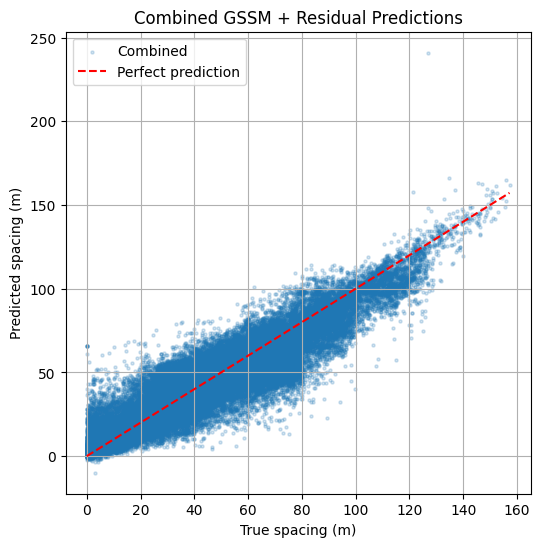

In [26]:
# Step 6: Evaluation + Plots for Base + Residual Models

import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Load trained base model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_test.shape[1]

class GSSM(nn.Module):
    def __init__(self, input_dim):
        super(GSSM, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, 1)
        self.fc_log_sigma = nn.Linear(64, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_log_sigma(h)
        return mu, log_sigma

model_base = GSSM(input_dim).to(device)
model_base.load_state_dict(torch.load("gssm_model_logspace.pth", map_location=device))
model_base.eval()

# --- Load residual model ---
class ResidualNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

res_model = ResidualNet(input_dim).to(device)
res_model.load_state_dict(torch.load("gssm_residual_net.pth", map_location=device))
res_model.eval()

# --- Predict base + residual ---
all_true, base_preds, final_preds = [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        mu, _ = model_base(X_batch)
        pred_base = torch.exp(mu)                 # predicted spacing
        pred_res = res_model(X_batch)             # residual correction (meters)
        pred_combined = pred_base + pred_res

        # convert log-space truth back to meters before error calc
        true_spacing = torch.exp(y_batch)

        all_true.extend(true_spacing.cpu().numpy().flatten())
        base_preds.extend(pred_base.cpu().numpy().flatten())
        final_preds.extend(pred_combined.cpu().numpy().flatten())


all_true = np.array(all_true)
base_preds = np.array(base_preds)
final_preds = np.array(final_preds)

# --- Error stats ---
def print_errors(name, preds):
    mae = np.mean(np.abs(preds - all_true))
    rmse = np.sqrt(np.mean((preds - all_true)**2))
    print(f"{name}: MAE={mae:.3f} m, RMSE={rmse:.3f} m")

print_errors("Base GSSM", base_preds)
print_errors("Combined (Base + Residual)", final_preds)

# --- Plot comparison ---
plt.figure(figsize=(6,6))
plt.scatter(all_true, final_preds, alpha=0.2, s=5, label="Combined")
plt.plot([all_true.min(), all_true.max()],
         [all_true.min(), all_true.max()],
         "r--", label="Perfect prediction")
plt.xlabel("True spacing (m)")
plt.ylabel("Predicted spacing (m)")
plt.title("Combined GSSM + Residual Predictions")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# Step 7: Compute GSSM Risk Scores (M) for All Interactions

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.special import erf
from scipy.sparse import issparse

# === Load preprocessed splits ===
data = np.load("gssm_train_val_test.npz", allow_pickle=True)

def ensure_dense_float(arr):
    if issparse(arr):
        arr = arr.toarray()
    if hasattr(arr, "toarray"):
        arr = arr.toarray()
    if hasattr(arr, "values"):
        arr = arr.values
    return np.asarray(arr, dtype=np.float32)

X_all = np.vstack([
    ensure_dense_float(data["X_train"]),
    ensure_dense_float(data["X_val"]),
    ensure_dense_float(data["X_test"]),
])
y_all = np.concatenate([
    ensure_dense_float(data["y_train"]),
    ensure_dense_float(data["y_val"]),
    ensure_dense_float(data["y_test"]),
])

# === Load the trained models ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_all.shape[1]

# Base GSSM network
class GSSM(nn.Module):
    def __init__(self, input_dim):
        super(GSSM, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, 1)
        self.fc_log_sigma = nn.Linear(64, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_log_sigma(h)
        return mu, log_sigma

# Residual model (optional)
class ResidualNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

# Instantiate and load weights
model_base = GSSM(input_dim).to(device)
model_base.load_state_dict(torch.load("gssm_model_logspace.pth", map_location=device))
model_base.eval()

try:
    res_model = ResidualNet(input_dim).to(device)
    res_model.load_state_dict(torch.load("gssm_residual_net.pth", map_location=device))
    res_model.eval()
    use_residual = True
except FileNotFoundError:
    print("Residual model not found; proceeding with base GSSM only.")
    use_residual = False

# === Predict μ̂(X), σ̂(X), and reconstructed spacing ===
batch_size = 512
mu_list, sigma_list, pred_spacing = [], [], []

with torch.no_grad():
    for i in range(0, X_all.shape[0], batch_size):
        xb = torch.tensor(X_all[i:i+batch_size], dtype=torch.float32).to(device)
        mu, log_sigma = model_base(xb)
        mu_list.extend(mu.cpu().numpy().flatten())
        sigma_list.extend(np.exp(log_sigma.cpu().numpy().flatten()))
        base_pred = torch.exp(mu)
        if use_residual:
            res_pred = res_model(xb)
            spacing_pred = base_pred + res_pred
        else:
            spacing_pred = base_pred
        pred_spacing.extend(spacing_pred.cpu().numpy().flatten())

mu_all = np.array(mu_list)
sigma_all = np.array(sigma_list)
pred_spacing = np.array(pred_spacing)
true_spacing = y_all.flatten()

# === Compute GSSM risk scores M(s,X) ===
def compute_gssm_M(s, mu, sigma):
    s = np.clip(s, 1e-6, None)  # prevent log(0)
    Fs = 0.5 * (1 + erf((np.log(s) - mu) / (np.sqrt(2) * sigma)))  # CDF of lognormal
    Ps = np.clip(1 - Fs, 1e-12, 1 - 1e-12)                        # survival prob
    M = np.log10(np.abs(np.log(0.5)) / np.abs(np.log(Ps)))
    return M

M_scores = compute_gssm_M(true_spacing, mu_all, sigma_all)

# === Save full dataset with predictions and M ===
gssm_results = pd.DataFrame({
    "true_spacing": true_spacing,
    "pred_spacing": pred_spacing,
    "mu_hat": mu_all,
    "sigma_hat": sigma_all,
    "GSSM_M": M_scores
})

gssm_results.to_csv("GSSM_Scored_Interactions.csv", index=False)
print(f"Saved: GSSM_Scored_Interactions.csv ({len(gssm_results)} rows)")
print(gssm_results.head())


C:\Users\msela\AppData\Local\Temp\ipykernel_6280\13892933.py:107: RuntimeWarning: divide by zero encountered in divide
  M = np.log10(np.abs(np.log(0.5)) / np.abs(np.log(Ps)))


Saved: GSSM_Scored_Interactions.csv (699275 rows)
   true_spacing  pred_spacing    mu_hat  sigma_hat    GSSM_M
0     16.495848     21.636112  3.265477   0.168677  2.354255
1     59.406624     56.855076  4.092964   0.119883  0.036142
2      3.099357     16.724352  2.856263   0.434764  4.281634
3     13.175641     11.107520  2.524589   0.237989 -0.108621
4     15.449346     16.436085  3.213373   0.640393  0.426296


Threshold u = 1.8536, number of exceedances = 20979
After cleaning: 20501 valid exceedances
Fitted GPD parameters: ξ = 0.1908, β = 0.6167


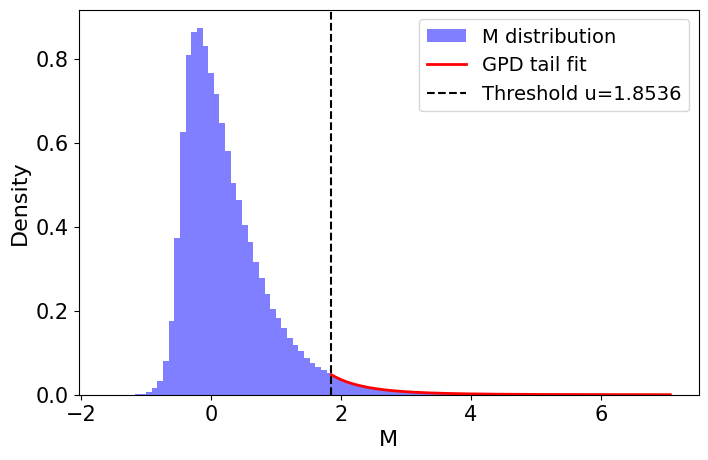

In [91]:
# Step 8: EVT Calibtation: Fitting a Generalized Pareto Distribution (GPD)

import numpy as np
import pandas as pd
from scipy.stats import genpareto
import matplotlib.pyplot as plt

# === Load M data (no AV/time columns) ===
df = pd.read_csv("GSSM_Scored_Interactions.csv")
M = df["GSSM_M"].dropna().values

# === 1. Define threshold at 97th percentile (top 3%) ===
u = np.percentile(M, 97)
exceedances = M[M > u] - u
print(f"Threshold u = {u:.4f}, number of exceedances = {len(exceedances)}")

# === 2. Clean and fit Generalized Pareto Distribution ===
exceedances = exceedances[np.isfinite(exceedances)]
print(f"After cleaning: {len(exceedances)} valid exceedances")

xi, loc, beta = genpareto.fit(exceedances, floc=0)
print(f"Fitted GPD parameters: ξ = {xi:.4f}, β = {beta:.4f}")

# === 3. Define exceedance probability function ===
def P_exceed(m):
    """Compute probability of M > m for any m >= u"""
    if m < u:
        return 1 - np.searchsorted(np.sort(M), m) / len(M)
    else:
        tail_prob = (1 + xi * (m - u) / beta) ** (-1 / xi)
        return (len(exceedances) / len(M)) * tail_prob

# === 5. Optional visualization (cleaned) ===
M_clean = M[np.isfinite(M)]
plt.figure(figsize=(8, 5))
plt.hist(M_clean, bins=100, density=True, color='blue', alpha=0.5, label="M distribution")

x = np.linspace(u, np.nanmax(M_clean), 200)
pdf_tail = genpareto.pdf(x - u, c=xi, scale=beta)
plt.plot(x, pdf_tail * (len(exceedances) / len(M_clean)), "r-", lw=2, label="GPD tail fit")

plt.axvline(u, color="k", linestyle="--", label=f"Threshold u={u:.4f}")
plt.legend(fontsize=14)
plt.xlabel("M", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Density", fontsize=16)
plt.savefig('GPD_Fit.png', dpi=300, bbox_inches='tight') 
plt.show()

In [94]:
# Finally, generating a unified dataset with maximum risk and exceedance probability per av per timestep

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.special import erf
from scipy.stats import genpareto

# Loading context features and GSSM results
context_features = pd.read_csv("GSSM_Context_Features.csv")
gssm = pd.read_csv("GSSM_Scored_Interactions.csv")

# Attaching identifiers (time, av_id) to GSSM results
gssm_full = pd.concat([
    context_features[["time", "av_id"]].reset_index(drop=True),
    gssm
], axis=1)

# Computing maximum risk per AV and time
risk_max = gssm_full.groupby(["av_id", "time"], as_index=False)["GSSM_M"].max()
risk_max = risk_max.rename(columns={"GSSM_M": "maximum_risk"})

# Loading state datasets and harmonizing
fb = pd.read_csv("Transformed_TGSIM_Foggy_Bottom_smoothed.csv")
i395 = pd.read_csv("Transformed_TGSIM_I-395_smoothed.csv")

i395 = i395.rename(columns={"acceleration_kf": "acceleration_kf_scalar"})

# Labeling dataset origin
fb["dataset"] = "FB"
i395["dataset"] = "I-395"

# Combining and keeping AV rows only (type_most_common = 4 usually represents AVs)
av_states = pd.concat([fb, i395], ignore_index=True)
av_states = av_states[av_states["type_most_common"] == 4]
av_states = av_states.rename(columns={'id': 'av_id'})

# Merging AV state data with risk values
merged = av_states.merge(risk_max, on=["av_id", "time"], how="left")

# Preparing data for exceedance probability
M = gssm["GSSM_M"].replace([np.inf, -np.inf], np.nan).dropna()
u = np.percentile(M, 97)
exceedances = M[M > u] - u
xi, loc, beta = genpareto.fit(exceedances, floc=0)
p_exceed_u = len(exceedances) / len(M)  # ~0.1 (10% tail)

# Adding exceedance probability from our GPD
def exceedance_prob(M_val):
    if pd.isna(M_val):
        return np.nan
    elif M_val <= u:
        # Empirical probability (fraction of values greater than M_val)
        return np.sum(M > M_val) / len(M)
    else:
        # EVT tail probability scaled by tail fraction
        return p_exceed_u * genpareto.sf(M_val - u, c=xi, scale=beta)

# Applying to each observation
merged["exceedance_prob"] = merged["maximum_risk"].apply(exceedance_prob)

# Selecting columns
final_df = merged[[
    "av_id", "time",
    "xloc_kf_smooth", "yloc_kf_smooth",
    "lane_kf", "speed_kf_smooth", "speed_kf_x", "speed_kf_y",
    "acceleration_kf_scalar", "acceleration_kf_x", "acceleration_kf_y",
    "maximum_risk", "exceedance_prob", "dataset"
]].rename(columns={"acceleration_kf_scalar": "accel_signed"})

# Saving
final_df.to_csv("AV_GSSM_PerTimestep.csv", index=False)
print("AV_GSSM_PerTimestep.csv with shape:", final_df.shape)

AV_GSSM_PerTimestep.csv with shape: (43694, 14)


## Calculation of Jerk

Jerk was computed as the derivative of signed acceleration using Kalman-smoothed values at 0.1 s intervals. Unrealistic spikes (|jerk| > 20 m/s³) were removed. The unified dataset contains per-timestep kinematics and jerk for all AVs across both sites.

In [108]:
# Unified AV Jerk Dataset (Foggy Bottom + I-395) with full kinematics
import pandas as pd
import numpy as np

dt = 0.1  # 10 Hz timestep

# Foggy Bottom
fb = pd.read_csv("Transformed_TGSIM_Foggy_Bottom_smoothed.csv")
fb = fb[fb["type_most_common"] == 4].copy().sort_values(["id", "time"])

fb["jerk"] = fb.groupby("id")["acceleration_kf_scalar"].diff() / dt
fb.loc[fb["jerk"].abs() > 20, "jerk"] = np.nan                           #removing unrealistic spikes
fb.loc[fb["acceleration_kf_scalar"].abs() < 0.3, "jerk"] = np.nan        #removing observations that don't qualify as reactions
fb["dataset"] = "FB"
fb = fb.rename(columns={"id": "av_id", "acceleration_kf_scalar": "accel_signed"})

fb = fb[[
    "av_id", "time", "xloc_kf_smooth", "yloc_kf_smooth",
    "lane_kf", "speed_kf_smooth", "speed_kf_x", "speed_kf_y",
    "accel_signed", "acceleration_kf_x", "acceleration_kf_y",
    "jerk", "dataset"
]]

# I-395
i395 = pd.read_csv("Transformed_TGSIM_I-395_smoothed.csv")
i395 = i395[i395["type_most_common"] == 4].copy().sort_values(["id", "time"])

i395["jerk"] = i395.groupby("id")["acceleration_kf"].diff() / dt
i395.loc[i395["jerk"].abs() > 20, "jerk"] = np.nan
i395.loc[i395["acceleration_kf"].abs() < 0.3, "jerk"] = np.nan    
i395["dataset"] = "I-395"
i395 = i395.rename(columns={"id": "av_id", "acceleration_kf": "accel_signed"})

i395 = i395[[
    "av_id", "time", "xloc_kf_smooth", "yloc_kf_smooth",
    "lane_kf", "speed_kf_smooth", "speed_kf_x", "speed_kf_y",
    "accel_signed", "acceleration_kf_x", "acceleration_kf_y",
    "jerk", "dataset"
]]

# Combine
jerk_all = pd.concat([fb, i395], ignore_index=True)
jerk_all.to_csv("AV_Jerk_PerTimestep.csv", index=False)

print(f"Unified jerk dataset saved: {len(jerk_all)} rows ({jerk_all['dataset'].value_counts().to_dict()})")


Unified jerk dataset saved: 43694 rows ({'FB': 34020, 'I-395': 9674})


## Calculation of Deceleration
Deceleration intensity was computed for all automated vehicles (AVs) across both datasets (Foggy Bottom and I-395). After standardizing column names and merging the data, signed acceleration values were used to derive deceleration intensity as the negative of acceleration when below zero, and left blank otherwise. The final dataset (`AV_Decel_PerTimestep.csv`) contains one record per AV–time step, including positional, kinematic, and deceleration attributes standardized across both sites.


In [115]:
# Unified Deceleration Intensity Dataset 
import pandas as pd
import numpy as np

# Loading both datasets
fb = pd.read_csv("Transformed_TGSIM_Foggy_Bottom_smoothed.csv")
i395 = pd.read_csv("Transformed_TGSIM_I-395_smoothed.csv")
fb["dataset"] = "FB"
i395["dataset"] = "I-395"

# Standardizing
fb["accel_signed"] = fb["acceleration_kf_scalar"]
i395["accel_signed"] = i395["acceleration_kf"]

# Combining
df = pd.concat([fb, i395], ignore_index=True)
avs = df[df["type_most_common"] == 4].copy().sort_values(["id", "time"])

# Deceleration intensity, no value if acceleration is poistive
avs["decel_intensity"] = np.where(avs["accel_signed"] < 0, -avs["accel_signed"], np.nan)
avs["decel_intensity"] = np.where(avs["decel_intensity"] < 0.3, np.nan, avs["decel_intensity"])

# Standardizing output columns
avs = avs.rename(columns={"id": "av_id"})
keep_cols = [
    "av_id", "time", "xloc_kf_smooth", "yloc_kf_smooth",
    "lane_kf", "speed_kf_smooth", "speed_kf_x", "speed_kf_y",
    "accel_signed", "acceleration_kf_x", "acceleration_kf_y",
    "decel_intensity", "dataset"
]

# Saving
decel_df = avs[keep_cols]
decel_df.to_csv("AV_Decel_PerTimestep.csv", index=False)
print(f"Saved AV_Decel_PerTimestep.csv with {len(decel_df)} rows (one per AV–timestep).")


Saved AV_Decel_PerTimestep.csv with 43694 rows (one per AV–timestep).


## Calculation of Headway
Headway was computed per AV and timestep. The nearest detected agent in the forward zones was selected if it met motion, type, and lane mapping conditions. For I-395, same-lane interactions (lane = –3) were enforced; for Foggy Bottom, multi-lane mapping (`lane_map_fb`) was applied.  

Headways were calculated as \( $h_t = d/v_{AV}$ \) and \( $h_s = d$ \), filtered to \( $h_t \le 8 s$ \), \($|\Delta v| \le 2 m/s$\), \($d < 120 m$\), and consistent acceleration. The output (`AV_Headway_PerTimestep_Unified.csv`) retains the closest valid leader per AV–time step.


In [31]:
import pandas as pd, numpy as np, json

# Dataset configurations
datasets = {
    "I-395": {
        "csv": "Transformed_TGSIM_I-395_smoothed.csv",
        "detections": "AV_Detection_Details_I395.json",
        "forward_zones": {"Main Fwd", "Narrow Fwd"},
        "allowed_types": {1, 2, 3, 4},
        "lane": -3  # same-lane restriction applies
    },
    "FB": {
        "csv": "Transformed_TGSIM_Foggy_Bottom_smoothed.csv",
        "detections": "AV_Detection_Details_FB.json",
        "forward_zones": {"Wide Fwd", "Main Fwd", "Narrow Fwd", "Side Fwd L"},
        "allowed_types": {3, 4, 5, 6, 7}
        # lane-free logic (multi-lane interaction allowed)
    }
}

# Mapping allowable lane correspondences for Foggy Bottom
lane_map_fb = {
    1:[1,40,15],2:[2,37,29],3:[3,48,34],4:[4,42,25],
    15:[15,46,3],25:[25,36,2],29:[29,41,1],34:[34,45,4],
    36:[36,2,37],37:[37,29],40:[40,15],41:[41,1,40],
    42:[42,25],45:[45,4,42],46:[46,3,48],48:[48,34]
}

def compute_headway(name, cfg):
    # Load base and detection data
    df = pd.read_csv(cfg["csv"])
    with open(cfg["detections"]) as f:
        det = pd.DataFrame(json.load(f))
    if det.empty:
        return pd.DataFrame()

    # Base trajectory subset
    df_t = df[["id", "time", "lane_kf", "speed_kf_smooth", "acceleration_kf_y", "type_most_common"]]

    # Merge AV kinematics at each timestep
    det = det.merge(df_t, left_on=["av_id", "time"], right_on=["id", "time"], how="left")
    det.rename(columns={
        "lane_kf": "lane_av",
        "speed_kf_smooth": "v_av",
        "acceleration_kf_y": "a_av",
        "type_most_common": "type_av"
    }, inplace=True)

    # Merge nearest agent record (±0.1 s)
    det = pd.merge_asof(det.sort_values("time"),
                        df_t.sort_values("time"),
                        on="time", direction="nearest", tolerance=0.1)
    det.rename(columns={
        "lane_kf": "lane_agent",
        "speed_kf_smooth": "v_agent",
        "acceleration_kf_y": "a_agent",
        "type_most_common": "type_agent"
    }, inplace=True)

    # Type, motion, and forward-zone filters
    det = det[
        (det["v_av"] > 0.1) &  # follower moving
        (det["type_agent"].isin(cfg["allowed_types"])) &
        (det["zones"].apply(lambda z: any(fz in cfg["forward_zones"] for fz in z)))
    ]

    # Lane logic
    if "lane" in cfg:  # I-395
        det = det[(det["lane_av"] == cfg["lane"]) & (det["lane_agent"] == cfg["lane"])]
    else:  # Foggy Bottom
        det = det[det.apply(lambda r: r["lane_agent"] in lane_map_fb.get(r["lane_av"], []), axis=1)]

    # Compute distance and relative velocity
    det["delta_v"] = det["v_av"] - det["v_agent"]

    # Ultra-AV car-following criteria:
    # (i) v_f > 0.1 m/s (already applied)
    # (ii) d_ij < 120 m
    # (iii) -5 ≤ a_f ≤ 5
    # (iv) |(Δd - ΣΔtΔv)/Δd| < 0.2 (spatial–temporal consistency)
    det = det[
        (det["distance"] < 120) &
        (det["a_av"].between(-5, 5))
    ]

    # Compute rolling consistency term
    det["delta_d"] = det.groupby("av_id")["distance"].diff().fillna(0)
    det["term_consistency"] = abs(det["delta_d"] - 0.1 * det["delta_v"]) / det["delta_d"].replace(0, np.nan)
    det = det[det["term_consistency"] < 0.2]

    # Compute headway (time gap)
    det["headway_t"] = np.where(det["v_av"] > 0, det["distance"] / det["v_av"], np.nan)
    det["headway_s"] = det["distance"]

    # Filter plausible following events
    det = det[(det["headway_t"] <= 12) & (det["delta_v"].abs() <= 2)]

    # Keep closest leader per AV–time
    det = det.sort_values("distance").groupby(["av_id", "time"], as_index=False).first()[["av_id", "time", "headway_t", "headway_s"]]

    # Merge back to AV base data
    av_df = df[df["type_most_common"] == 4].rename(columns={"id": "av_id"})
    av_df["dataset"] = name
    return av_df.merge(det, on=["av_id", "time"], how="left")[[
        "av_id", "time", "xloc_kf_smooth", "yloc_kf_smooth", "lane_kf",
        "speed_kf_smooth", "speed_kf_x", "speed_kf_y",
        "acceleration_kf_x", "acceleration_kf_y", "headway_t", "headway_s", "dataset"
    ]]

# Run across datasets and save unified output
res = [compute_headway(n, c) for n, c in datasets.items()]
res = [r for r in res if not r.empty]

if res:
    out = pd.concat(res, ignore_index=True)
    out.to_csv("AV_Headway_PerTimestep_Unified.csv", index=False)
    print(f"Saved {len(out)} rows.")
else:
    print("No valid data produced.")


Saved 43694 rows.


## Calculation of String Stability Gain 

### Step 1: Modeling follower reaction time
We estimated the driver reaction time (τ) for each AV–follower pair using time-aligned acceleration histories. For each timestep, the nearest follower detected in a rear zone and within affine spacing distance was selected. Using 5 s acceleration windows, the cross-correlation lag between the leader and follower acceleration profiles was computed to obtain τ, representing the delay in the follower’s response. Unrealistic delays (< 0.3 s or > 4 s) were discarded. A Generalized Additive Model (GAM) was then fitted to explain τ as a smooth function of leader and follower speeds, distance, accelerations, and lane and road type, allowing us to capture nonlinear and context-specific reaction dynamics.

In [64]:
import pandas as pd
import numpy as np
import json
from scipy.signal import correlate
from scipy.stats import zscore
from tqdm import tqdm

# --- Load datasets ---
fb = pd.read_csv("Transformed_TGSIM_Foggy_Bottom_smoothed.csv")
i395 = pd.read_csv("Transformed_TGSIM_I-395_smoothed.csv")

with open("AV_Detection_Details_FB.json") as f:
    det_fb = pd.DataFrame(json.load(f))
with open("AV_Detection_Details_I395.json") as f:
    det_i395 = pd.DataFrame(json.load(f))

# --- Harmonize follower types ---
map_i395 = {1: "Passenger Car", 2: "Truck", 3: "Bus", 4: "AV"}
map_fb = {3: "Passenger Car", 7: "Truck", 6: "Bus", 4: "AV", 5: "Motorcycle"}

fb["type_most_common"] = fb["type_most_common"].map(map_fb)
i395["type_most_common"] = i395["type_most_common"].map(map_i395)
fb.dropna(subset=["type_most_common"], inplace=True)
i395.dropna(subset=["type_most_common"], inplace=True)

# --- Lane mappings ---
follower_mapping_i395 = {-3: [-3]}
follower_mapping_fb = {
    1: [1, 41, 29], 2: [2, 36, 25], 3: [3, 46, 15], 4: [4, 45, 34],
    36: [36, 25], 37: [37, 2, 36], 40: [40, 1, 41], 41: [41, 29],
    42: [42, 4, 45], 45: [45, 34], 46: [46, 15], 48: [48, 3, 46]
}
rear_zones = {"Rear", "Side Rear L", "Side Rear R"}

# --- Tau estimator ---
def estimate_tau(a_lead, a_follow, timestep=0.1):
    n = min(len(a_lead), len(a_follow))
    if n < 15:
        return np.nan
    if np.std(a_lead) == 0 or np.std(a_follow) == 0:
        return np.nan

    # Normalize signals
    a_lead, a_follow = zscore(a_lead[-n:]), zscore(a_follow[-n:])

    if np.isnan(a_lead).any() or np.isnan(a_follow).any():
        return np.nan

    # Cross-correlation (positive lag = follower lags leader)
    corr = correlate(a_follow, a_lead, mode="full")
    lags = np.arange(-n + 1, n)
    lag = lags[np.argmax(corr)]

    if lag <= 0:  # follower should lag leader
        return np.nan

    tau = lag * timestep
    return tau if 0.3 <= tau <= 4.0 else np.nan

# --- Tau computation ---
def compute_taus(det_df, traj_df, follower_map, accel_col, road_label):
    taus = []
    det_df = det_df[det_df["zones"].apply(lambda z: any(rz in z for rz in rear_zones))]

    # Pre-group trajectories by ID for fast lookup
    traj_by_id = {i: d.sort_values("time") for i, d in traj_df.groupby("id")}
    grouped = det_df.groupby(["av_id", "time"])

    for (av_id, t), group in tqdm(grouped, desc=f"Processing {road_label}", total=len(grouped)):
        av_lane_series = traj_df.loc[
            (traj_df["id"] == av_id) & (traj_df["time"] == t), "lane_kf"
        ]
        if av_lane_series.empty:
            continue
        av_lane = av_lane_series.iloc[0]

        # Candidate followers in mapped lanes
        candidate_ids = []
        for a in group["agent_id"]:
            lane_match = traj_df.loc[
                (traj_df["id"] == a) & (traj_df["time"] == t), "lane_kf"
            ]
            if lane_match.isin(follower_map.get(av_lane, [])).any():
                candidate_ids.append(a)

        if not candidate_ids:
            continue

        candidates = group[group["agent_id"].isin(candidate_ids)]
        nearest = candidates.loc[candidates["distance"].idxmin()]

        # Distance filter
        av_speed_series = traj_df.loc[
            (traj_df["id"] == av_id) & (traj_df["time"] == t), "speed_kf_smooth"
        ]
        if av_speed_series.empty:
            continue
        av_speed = av_speed_series.iloc[0]
        d_th = 4.0 + 1.5 * av_speed + 5.0
        if nearest["distance"] > d_th:
            continue

        # Trajectories
        av_hist = traj_by_id.get(av_id)
        ag_hist = traj_by_id.get(nearest["agent_id"])
        if av_hist is None or ag_hist is None:
            continue

        av_hist = av_hist[av_hist["time"] <= t].tail(50)
        ag_hist = ag_hist[ag_hist["time"] <= t].tail(50)
        if len(av_hist) < 15 or len(ag_hist) < 15:
            continue

        # Compute tau
        tau = estimate_tau(av_hist[accel_col].values, ag_hist[accel_col].values)
        if np.isnan(tau):
            continue

        taus.append({
            "leader_speed": av_hist["speed_kf_smooth"].iloc[-1],
            "follower_speed": ag_hist["speed_kf_smooth"].iloc[-1],
            "distance": nearest["distance"],
            "lane": ag_hist["lane_kf"].iloc[-1],
            "follower_type": ag_hist["type_most_common"].iloc[-1],
            "road_type": road_label,
            "tau": tau
        })

    return pd.DataFrame(taus)

# --- Run for both datasets ---
taus_fb = compute_taus(det_fb, fb, follower_mapping_fb, "acceleration_kf_scalar", "Foggy_Bottom")
taus_i395 = compute_taus(det_i395, i395, follower_mapping_i395, "acceleration_kf", "I-395")

# --- Combine and save ---
tau_df = pd.concat([taus_fb, taus_i395], ignore_index=True)
tau_df.to_csv("Follower_Lags.csv", index=False)

print("Saved Follower_Lags.csv with", len(tau_df), "entries.")


Processing I-395: 100%|████████████████████████████████████████████████████████████| 9504/9504 [36:20<00:00,  4.36it/s]


Saved Follower_Lags.csv with 1673 entries.


In [80]:
# Fitting a GAM

# Fitting a GAM with lane-type generalization

import pandas as pd
import numpy as np
from pygam import LinearGAM, s, f as fac

# Load data
tau_df = pd.read_csv("Follower_Lags.csv").dropna(subset=["tau"])

# Map numeric lanes to lane-type categories
lane_type_map = {
    1: "intersection - 3 leg - sig", 2: "intersection - 4 leg - sig", 3: "intersection - 4 leg - sig", 4: "intersection - 4 leg - unsig",
    15: "street lane - 2 way - sig", 25: "street lane - 1 way - sig", 29: "street lane - 2 way - sig", 34: "street lane - 2 way - stop",
    36: "entry ped zone - 4 leg - sig", 41: "entry ped zone - 3 leg - sig", 45: "entry ped zone - 4 leg - unsig", 46: "entry ped zone - 4 leg - sig",
    37: "exit ped zone - 4 leg - sig", 40: "exit ped zone - 3 leg - sig", 42: "exit ped zone - 4 leg - unsig", 48: "exit ped zone - 4 leg - sig",
    -3: "highway lane"
}

tau_df["lane_type"] = tau_df["lane"].map(lane_type_map)
tau_df["lane_type"].fillna("unknown", inplace=True)

# Compute leader acceleration
frame_dt = 0.1  # seconds per frame
tau_df["leader_accel"] = (
    tau_df.groupby(["road_type", "lane_type"])["leader_speed"]
    .diff() / frame_dt
)
tau_df["leader_accel"] = tau_df["leader_accel"].fillna(0)

# Encode categorical variables
for col in ["lane_type", "road_type", "follower_type"]:
    tau_df[col] = tau_df[col].astype("category").cat.codes

# Define predictors and target
X = tau_df[[
    "leader_speed",
    "follower_speed",
    "distance",
    "leader_accel",
    "lane_type",
    "follower_type"
]]
y = tau_df["tau"]

# Fit the GAM
gam = LinearGAM(
    s(0) + s(1) + s(2) + s(3) + fac(4) + fac(5)
).fit(X, y)

print(gam.summary())


C:\Users\msela\AppData\Local\Temp\ipykernel_20368\1292851595.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tau_df["lane_type"].fillna("unknown", inplace=True)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     53.4961
Link Function:                     IdentityLink Log Likelihood:                                 -2017.5086
Number of Samples:                         1673 AIC:                                             4144.0095
                                                AICc:                                             4147.749
                                                GCV:                                                0.6045
                                                Scale:                                              0.5698
                                                Pseudo R-Squared:                                   0.4434
Feature Function                  Lam

C:\Users\msela\AppData\Local\Temp\ipykernel_20368\1292851595.py:52: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


### Step 2: Calculation of Gain
The code identifies the first valid follower for each automated vehicle (AV) at every timestep, computes the reaction delay (τ) using the fitted Generalized Additive Model (GAM), and bounds it between 0.3 s and 4.0 s to exclude unrealistic responses. It then calculates the instantaneous string stability gain as the ratio of follower to leader acceleration. All relevant AV kinematic attributes and the computed gain are stored for each timestep, producing the unified dataset `AV_FollowerGain_PerTimestep_Unified.csv`.

In [89]:
import json, joblib

# Save the trained GAM
joblib.dump(gam, "gam_model.pkl")

# Save category mappings based on the training dataframe
cat_maps = {
    "lane_type": dict(enumerate(tau_df["lane_type"].astype("category").cat.categories)),
    "follower_type": dict(enumerate(tau_df["follower_type"].astype("category").cat.categories)),
}
with open("gam_category_maps.json", "w") as f:
    json.dump(cat_maps, f)

In [98]:
import pandas as pd
import numpy as np
import json
import joblib
from tqdm import tqdm

# --- Load trained GAM and mappings ---
gam = joblib.load("gam_model.pkl")
with open("gam_category_maps.json") as f:
    cat_maps = json.load(f)

lane_codes = {v: int(k) for k, v in cat_maps["lane_type"].items()}
follower_codes = {v: int(k) for k, v in cat_maps["follower_type"].items()}

# --- Load trajectory data ---
fb = pd.read_csv("Transformed_TGSIM_Foggy_Bottom_smoothed.csv")
i395 = pd.read_csv("Transformed_TGSIM_I-395_smoothed.csv")

# --- Harmonize type mapping ---
map_i395 = {1: "Passenger Car", 2: "Truck", 3: "Bus", 4: "AV"}
map_fb = {3: "Passenger Car", 7: "Truck", 6: "Bus", 4: "AV", 5: "Motorcycle"}

fb["type_most_common"] = fb["type_most_common"].map(map_fb)
i395["type_most_common"] = i395["type_most_common"].map(map_i395)

# --- Standardize acceleration column names ---
fb["accel_used"] = fb["acceleration_kf_scalar"]
i395["accel_used"] = i395["acceleration_kf"]

# --- Keep only vehicle rows ---
vehicle_types = ["Passenger Car", "Truck", "Bus", "AV"]
fb = fb[fb["type_most_common"].isin(vehicle_types)]
i395 = i395[i395["type_most_common"].isin(vehicle_types)]

# --- Lane → lane_type mapping ---
lane_type_map = {
    1: "intersection - 3 leg - sig", 2: "intersection - 4 leg - sig", 3: "intersection - 4 leg - sig", 4: "intersection - 4 leg - unsig",
    15: "street lane - 2 way - sig", 25: "street lane - 1 way - sig", 29: "street lane - 2 way - sig", 34: "street lane - 2 way - stop",
    36: "entry ped zone - 4 leg - sig", 41: "entry ped zone - 3 leg - sig", 45: "entry ped zone - 4 leg - unsig", 46: "entry ped zone - 4 leg - sig",
    37: "exit ped zone - 4 leg - sig", 40: "exit ped zone - 3 leg - sig", 42: "exit ped zone - 4 leg - unsig", 48: "exit ped zone - 4 leg - sig",
    -3: "highway lane"
}

def assign_lane_type(df):
    df["lane_type"] = df["lane_kf"].map(lane_type_map)
    df["lane_type"] = df["lane_type"].fillna("unknown")
    return df

fb = assign_lane_type(fb)
i395 = assign_lane_type(i395)

# --- Lane follower maps ---
follower_mapping_fb = {
    1:[1,41,29],2:[2,36,25],3:[3,46,15],4:[4,45,34],
    36:[36,25],37:[37,2,36],40:[40,1,41],41:[41,29],
    42:[42,4,45],45:[45,34],46:[46,15],48:[48,3,46]
}
follower_mapping_i395 = {-3:[-3]}

# --- τ prediction helper ---
def predict_tau(gam, leader_speed, follower_speed, distance, leader_accel, lane_type, follower_type):
    lane_code = lane_codes.get(lane_type, 0)
    follower_code = follower_codes.get(follower_type, 0)
    X_pred = [[leader_speed, follower_speed, distance, leader_accel, lane_code, follower_code]]
    tau = gam.predict(X_pred)[0]
    return np.clip(tau, 0.3, 4.0)

# --- Follower gain helper ---
def follower_gain(f_accel, a_accel):
    if abs(a_accel) < 0.1: return np.nan
    if abs(f_accel) < 0.1: return np.nan
    if abs(a_accel) > 10: return np.nan
    if abs(f_accel) > 10: return np.nan
    if f_accel / a_accel < 0: return np.nan
    return f_accel / a_accel

# --- Core routine ---
def compute_gain_dataset(traj_df, follower_map, gam, label):
    out = []
    traj_by_id = {i: d.sort_values("time") for i, d in traj_df.groupby("id")}
    av_ids = traj_df.loc[traj_df["type_most_common"] == "AV", "id"].unique()

    for av_id in tqdm(av_ids, desc=f"{label} AVs"):
        av_traj = traj_by_id[av_id]
        for _, row in av_traj.iterrows():
            t, lane = row["time"], row["lane_kf"]

            # find potential followers
            possible_followers = traj_df[traj_df["lane_kf"].isin(follower_map.get(lane, []))]
            possible_followers = possible_followers.iloc[(possible_followers["time"] - t).abs().argsort()[:1]]

            if possible_followers.empty:
                tau = np.nan
                gain = np.nan
            else:
                f = possible_followers.iloc[0]
                leader_speed = row["speed_kf_smooth"]
                follower_speed = f["speed_kf_smooth"]
                distance = np.hypot(
                    row["xloc_kf_smooth"] - f["xloc_kf_smooth"],
                    row["yloc_kf_smooth"] - f["yloc_kf_smooth"]
                )

                prev_speed = av_traj.iloc[(av_traj["time"] - (t - 0.1)).abs().argsort()[:1]]
                leader_accel = (row["speed_kf_smooth"] - prev_speed["speed_kf_smooth"].values[0]) / 0.1

                # --- Predict tau ---
                tau = predict_tau(
                    gam,
                    leader_speed,
                    follower_speed,
                    distance,
                    leader_accel,
                    row["lane_type"],
                    f["type_most_common"]
                )

                # --- Get leader acceleration at (t - tau) ---
                if np.isnan(tau):
                    gain = np.nan
                else:
                    if (t - tau) < av_traj["time"].min() or (t - tau) > av_traj["time"].max():
                        gain = np.nan
                    else:
                        lead_past = av_traj.iloc[(av_traj["time"] - (t - tau)).abs().argsort()[:1]]
                        lead_accel_tau = lead_past["accel_used"].values[0]
                        gain = follower_gain(f["accel_used"], lead_accel_tau)

            out.append({
                "av_id": av_id,
                "time": t,
                "xloc_kf_smooth": row["xloc_kf_smooth"],
                "yloc_kf_smooth": row["yloc_kf_smooth"],
                "lane_kf": lane,
                "lane_type": row["lane_type"],
                "speed_kf_smooth": row["speed_kf_smooth"],
                "speed_kf_x": row["speed_kf_x"],
                "speed_kf_y": row["speed_kf_y"],
                "accel_signed": row["accel_used"],
                "acceleration_kf_x": row["acceleration_kf_x"],
                "acceleration_kf_y": row["acceleration_kf_y"],
                "follower_gain": gain,
                "tau_pred": tau,
                "dataset": label
            })
    return pd.DataFrame(out)

# --- Run for both datasets ---
gain_fb = compute_gain_dataset(fb, follower_mapping_fb, gam, "FB")
gain_i395 = compute_gain_dataset(i395, follower_mapping_i395, gam, "I-395")

# --- Combine and save ---
gain_df = pd.concat([gain_fb, gain_i395], ignore_index=True)
gain_df.to_csv("AV_FollowerGain_PerTimestep_Unified.csv", index=False)

print("Saved gain dataset:", gain_df.shape)


I-395 AVs: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [40:46<00:00, 116.48s/it]


Saved gain dataset: (43694, 15)


## Visualization of Metrics

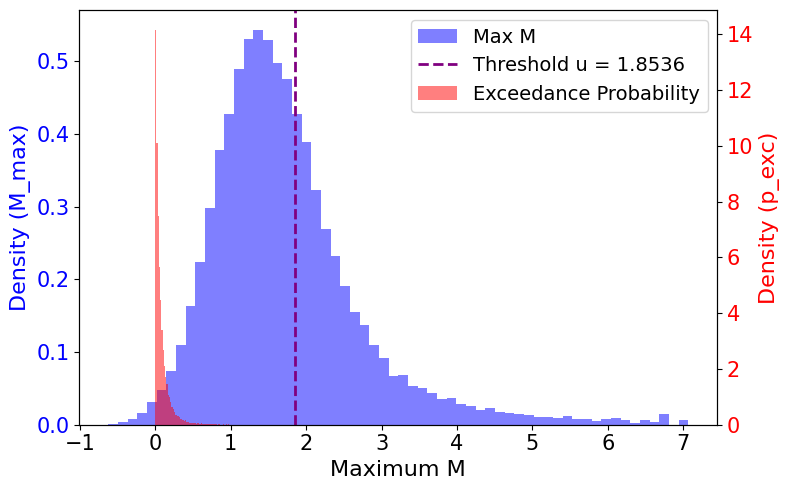

In [105]:
# Maximum M and Exceedance Probability
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
merged = pd.read_csv("AV_GSSM_PerTimestep.csv")

# Clean Maximum M: remove NaN, inf, -inf
M_clean = merged["maximum_risk"].replace([np.inf, -np.inf], np.nan).dropna()

# Threshold and GPD parameters (97th percentile)
u = 1.8536
xi = 0.1908
beta = 0.6167

# Plot
fig, ax1 = plt.subplots(figsize=(8,5))

# Histogram of Max M
ax1.hist(M_clean, bins=60, color='blue', alpha=0.5, density=True, label='Max M')
ax1.axvline(u, color='purple', linestyle='--', lw=2, label=f'Threshold u = {u:.4f}')
ax1.set_xlabel('Maximum M', fontsize = 16)
ax1.tick_params(axis='x', labelsize=15)
ax1.set_ylabel('Density (M_max)', color='blue',fontsize = 16)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=15)

# Clean exceedance probabilities too
p_clean = merged["exceedance_prob"].replace([np.inf, -np.inf], np.nan).dropna()

# Exceedance probability histogram (secondary axis)
ax2 = ax1.twinx()
ax2.hist(p_clean, bins=60, color='red', alpha=0.5, density=True, label='Exceedance Probability')
ax2.set_ylabel('Density (p_exc)', color='red', fontsize = 16)
ax2.tick_params(axis='y', labelcolor='red', labelsize=15)

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right', fontsize = 14)

plt.tight_layout()
plt.savefig('Max_M_Dist.png', dpi=300, bbox_inches='tight') 
plt.show()


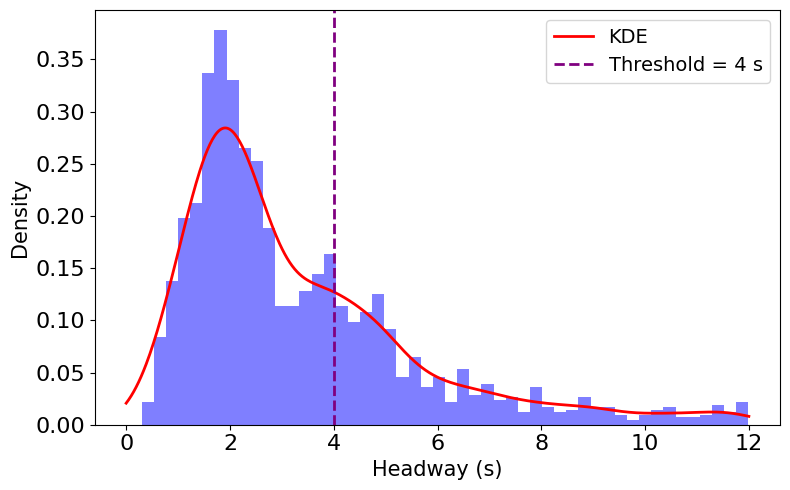

In [47]:
# Headway
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Load unified dataset
headway_df = pd.read_csv("AV_Headway_PerTimestep_Unified.csv")
headway_clean = headway_df["headway_t"].replace([np.inf, -np.inf], np.nan).dropna()

# Histogram
plt.figure(figsize=(8,5))
counts, bins, _ = plt.hist(headway_clean, bins=50, color='blue', alpha=0.5, density=True)

# KDE curve
kde = gaussian_kde(headway_clean)
x_vals = np.linspace(0, 12, 500)
plt.plot(x_vals, kde(x_vals), color='red', lw=2, label='KDE')

# Threshold
plt.axvline(4, color='purple', linestyle='--', lw=2, label='Threshold = 4 s')

plt.xlabel("Headway (s)", fontsize=15)
plt.xticks(fontsize=16)
plt.ylabel("Density", fontsize=15)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("AV_Headway_Distribution.png", dpi=300, bbox_inches="tight")
plt.show()


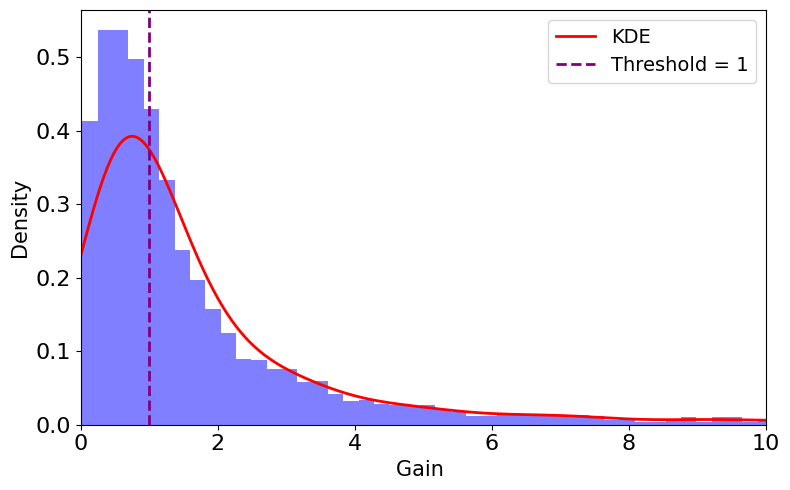

In [103]:
# Gain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Load unified dataset
gain_df = pd.read_csv("AV_FollowerGain_PerTimestep_Unified.csv")
gain_clean = gain_df["follower_gain"].replace([np.inf, -np.inf], np.nan).dropna()

# Histogram
plt.figure(figsize=(8,5))
counts, bins, _ = plt.hist(gain_clean, bins=250, color='blue', alpha=0.5, density=True)

# KDE curve
kde = gaussian_kde(gain_clean)
x_vals = np.linspace(0, 12, 500)
plt.plot(x_vals, kde(x_vals), color='red', lw=2, label='KDE')

# Threshold
plt.axvline(1, color='purple', linestyle='--', lw=2, label='Threshold = 1')

plt.xlabel("Gain ", fontsize=15)
plt.xticks(fontsize=16)
plt.xlim(0,10)
plt.ylabel("Density", fontsize=15)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("AV_Follower-Gain_Distribution.png", dpi=300, bbox_inches="tight")
plt.show()


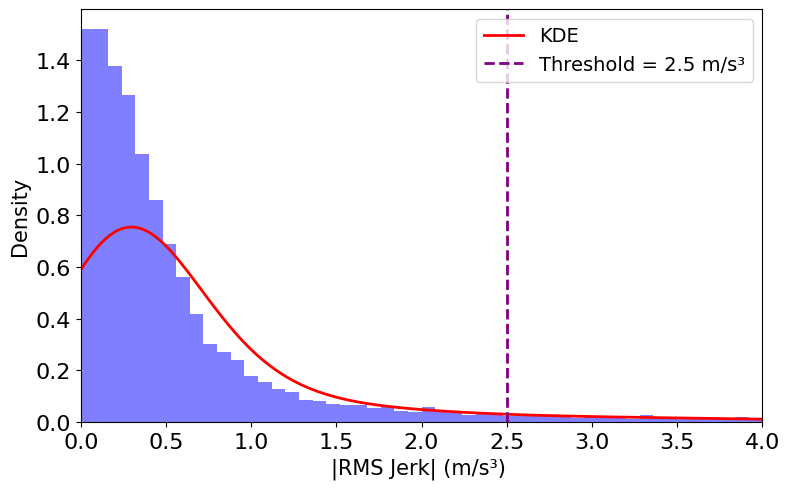

In [112]:
# Jerk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Load unified dataset
gain_df = pd.read_csv("AV_Jerk_PerTimestep.csv")
gain_clean = gain_df["jerk"].abs().replace([np.inf, -np.inf], np.nan).dropna()

# Histogram
plt.figure(figsize=(8,5))
counts, bins, _ = plt.hist(gain_clean, bins=250, color='blue', alpha=0.5, density=True)

# KDE curve
kde = gaussian_kde(gain_clean)
x_vals = np.linspace(0, 12, 500)
plt.plot(x_vals, kde(x_vals), color='red', lw=2, label='KDE')

# Threshold
plt.axvline(2.5, color='purple', linestyle='--', lw=2, label='Threshold = 2.5 m/s³')

plt.xlabel("|RMS Jerk| (m/s³) ", fontsize=15)
plt.xticks(fontsize=16)
plt.xlim(0,4)
plt.ylabel("Density", fontsize=15)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("AV_Jerk_Distribution.png", dpi=300, bbox_inches="tight")
plt.show()


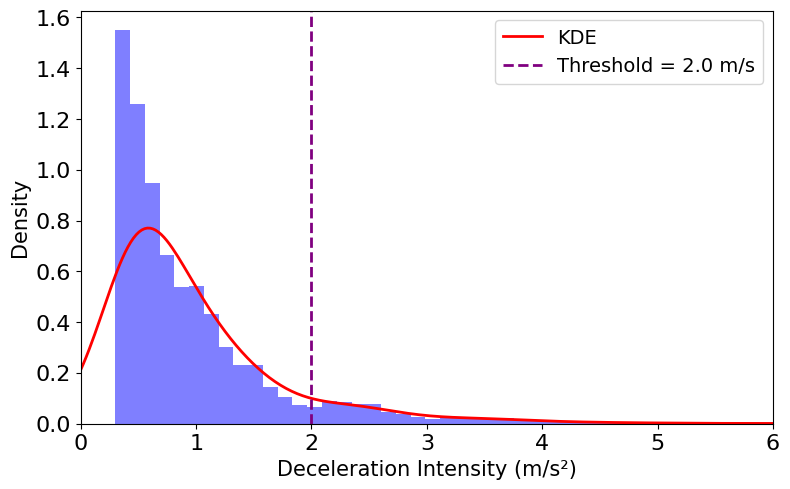

In [120]:
# Deceleration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Load unified dataset
gain_df = pd.read_csv("AV_Decel_PerTimestep.csv")
gain_clean = gain_df["decel_intensity"].abs().replace([np.inf, -np.inf], np.nan).dropna()

# Histogram
plt.figure(figsize=(8,5))
counts, bins, _ = plt.hist(gain_clean, bins=300, color='blue', alpha=0.5, density=True)

# KDE curve
kde = gaussian_kde(gain_clean)
x_vals = np.linspace(0, 12, 500)
plt.plot(x_vals, kde(x_vals), color='red', lw=2, label='KDE')

# Threshold
plt.axvline(2, color='purple', linestyle='--', lw=2, label="Threshold = 2.0 m/s")

plt.xlabel("Deceleration Intensity (m/s²)", fontsize=15)
plt.xticks(fontsize=16)
plt.xlim(0,6)
plt.ylabel("Density", fontsize=15)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("AV_Decel_Distribution.png", dpi=300, bbox_inches="tight")
plt.show()
